In [3]:
pip install kfp minio trino numpy pandas boto3 pyspark

Note: you may need to restart the kernel to use updated packages.


In [4]:
import kfp
from kfp.dsl import pipeline, component, Output, Dataset, Input
from minio import Minio
from typing import NamedTuple
from datetime import datetime
from trino.dbapi import connect
import csv
import boto3

In [41]:
# from trino.dbapi import connect
# from trino.auth import BasicAuthentication
# import csv
# import boto3
# from datetime import datetime
# import kfp.local
# from kfp.dsl import component

# import kfp
# from kfp.local import LocalClient

# def initialize_kfp():
#     """
#     Properly initialize Kubeflow Pipelines local runner
    
#     Returns:
#         LocalClient: Initialized local KFP client
#     """
#     try:
#         # Create a local runner client
#         local_client = LocalClient()
#         return local_client
#     except Exception as e:
#         print(f"Error initializing KFP local runner: {e}")
#         raise


# # @component(base_image='bitnami/spark:3.5', packages_to_install=['trino', 'boto3'])
# def fetch_data_trino(filename: str, minio_bucket: str) -> str:
#     """
#     Fetches customer segmentation data from Trino and saves to MinIO
    
#     Args:
#         filename: Local filename to save the CSV temporarily
#         minio_bucket: MinIO bucket name to upload to
        
#     Returns:
#         str: Path to the file in MinIO
#     """

#     # Initialize the local execution environment
#     local_runner = initialize_kfp()

#     # Trino Connection Details
#     TRINO_HOST = "192.168.80.155"
#     TRINO_PORT = "30071"
#     TRINO_USER = "ctzn.bank"
#     TRINO_PASSWORD = "ctzn.bank_123"
#     TRINO_CATALOG = "iceberg"
#     TRINO_SCHEMA = "silver_crmuser"
#     TRINO_HTTP_SCHEME = "https"

#     # SQL Query with fixed syntax
#     SQL_QUERY = """ 
# WITH recent_customers AS (
#     SELECT DISTINCT 
#         g.cif_id
#     FROM 
#         gold.dim_gam AS g
#     WHERE 
#         CAST(DATE_PARSE(SUBSTRING(g.acct_opn_date, 1, 19), '%Y-%m-%dT%H:%i:%s') AS DATE) >= CURRENT_DATE - INTERVAL '5' YEAR
# ),

# account_activity AS (
#     SELECT 
#         a.cif_id,
#         SUM(COALESCE(a.total_credit_tran_vol, 0) - COALESCE(a.total_debit_tran_vol, 0)) AS balance,
#         COUNT(DISTINCT a.nepali_month)/60.0 AS balance_frequency,
#         SUM(COALESCE(a.total_debit_tran_vol, 0)) AS purchases,
#         MAX(COALESCE(a.total_debit_tran_vol, 0)) AS oneoff_purchases,
#         SUM(COALESCE(a.total_debit_tran_vol, 0)) - MAX(COALESCE(a.total_debit_tran_vol, 0)) AS installments_purchases,
#         SUM(CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 AND COALESCE(a.total_debit_tran_vol, 0) = 0 
#                 THEN COALESCE(a.total_credit_tran_vol, 0) ELSE 0 END) AS cash_advance,
#         COUNT(DISTINCT a.foracid)/60.0 AS purchases_frequency,
#         COUNT(DISTINCT CASE WHEN COALESCE(a.total_debit_tran_vol, 0) > 100000 THEN a.foracid END)/60.0 AS oneoff_purchases_frequency,
#         COUNT(DISTINCT CASE WHEN COALESCE(a.total_debit_tran_vol, 0) BETWEEN 1 AND 100000 THEN a.foracid END)/60.0 AS purchases_installments_frequency,
#         COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 THEN a.foracid END)/60.0 AS cash_advance_frequency,
#         COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 THEN a.foracid END) AS cash_advance_trx,
#         COUNT(DISTINCT a.foracid) AS purchases_trx,
#         SUM(COALESCE(a.total_credit_tran_vol, 0)) AS payments,
#         COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) >= COALESCE(a.total_debit_tran_vol, 0) 
#                             THEN a.nepali_month END)/60.0 AS prc_full_payment
#     FROM 
#         gold.mv_fact_deposit_account_insights a
#     JOIN 
#         recent_customers rc ON a.cif_id = rc.cif_id
#     GROUP BY 
#         a.cif_id
# ),

# salary_stats AS (
#     SELECT 
#         APPROX_PERCENTILE(COALESCE(salary_per_month, 0), 0.5) AS median_salary,
#         APPROX_PERCENTILE(COALESCE(salary_per_month, 0), 0.05) AS fifth_percentile_salary
#     FROM 
#         gold.dim_customers
# ),

# customer_profile AS (
#     SELECT 
#         g.cif_id,
#         DATE_DIFF('year', 
#                 CAST(DATE_PARSE(SUBSTRING(MIN(g.acct_opn_date), 1, 19), '%Y-%m-%dT%H:%i:%s') AS DATE), 
#                 CURRENT_DATE) AS tenure,
#         (SELECT fifth_percentile_salary FROM salary_stats) AS minimum_payments
#     FROM 
#         gold.dim_gam g
#     LEFT JOIN 
#         gold.dim_customers c ON g.cif_id = c.cif_id
#     GROUP BY 
#         g.cif_id
# )

# SELECT 
#     aa.cif_id AS custid,
#     aa.balance,
#     aa.balance_frequency,
#     aa.purchases,
#     aa.oneoff_purchases,
#     aa.installments_purchases,
#     aa.cash_advance,
#     aa.purchases_frequency,
#     aa.oneoff_purchases_frequency,
#     aa.purchases_installments_frequency,
#     aa.cash_advance_frequency,
#     aa.cash_advance_trx,
#     aa.purchases_trx,
#     (SELECT median_salary * 3 FROM salary_stats) AS credit_limit,
#     aa.payments,
#     cp.minimum_payments,
#     aa.prc_full_payment,
#     cp.tenure
# FROM 
#     account_activity aa
# JOIN 
#     customer_profile cp ON aa.cif_id = cp.cif_id
# ORDER BY 
#     aa.cif_id
# """

#     try:
#         # Connect to Trino
#         conn = connect(
#             host=TRINO_HOST,
#             port=TRINO_PORT,
#             user=TRINO_USER,
#             auth=BasicAuthentication(TRINO_USER, TRINO_PASSWORD),
#             catalog=TRINO_CATALOG,
#             schema=TRINO_SCHEMA,
#             http_scheme=TRINO_HTTP_SCHEME,
#             request_timeout=600,
#             verify=False
#         )
#         cursor = conn.cursor()

#         # Execute query and save to CSV
#         cursor.execute(SQL_QUERY)
#         columns = [desc[0] for desc in cursor.description]
        
#         with open(filename, 'w', newline='', encoding='utf-8') as f:
#             writer = csv.writer(f)
#             writer.writerow(columns)
#             for row in cursor:
#                 writer.writerow(row)

#         # Upload to MinIO
#         minio_client = boto3.client(
#             's3',
#             endpoint_url="http://192.168.80.155:32000",
#             aws_access_key_id="admin",
#             aws_secret_access_key="dlyticaD123"
#         )
        
#         current_date = datetime.now().strftime("%Y-%m-%d")
#         minio_path = f"data/customer_segmentation_raw_data_{current_date}.csv"
#         minio_client.upload_file(filename, minio_bucket, minio_path)

#         return minio_path

#     except Exception as e:
#         print(f"Error in fetch_data_trino: {str(e)}")
#         raise

# # Example usage (when running locally)
# if __name__ == "__main__":
#     # Use the local runner if needed
#     local_runner = initialize_kfp()
    
#     result = fetch_data_trino(
#         filename='/tmp/AI360CDP_raw_data.csv',
#         minio_bucket='ai360ctzn-customer-segmentation'
#     )
#     print(f"Data saved to MinIO at: {result}")

In [11]:
pip install boto3 kfp minio trino

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 831.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 29.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 7.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
# Kubeflow Pipelines Local Initialization

import kfp
import os

def initialize_kfp():
    """
    Alternative method to initialize Kubeflow Pipelines local execution
    
    Returns:
        str: Path to the local execution directory
    """
    try:
        # Create a temporary directory for local execution
        local_execution_dir = os.path.join(os.getcwd(), 'kfp_local_run')
        os.makedirs(local_execution_dir, exist_ok=True)
        
        # Set the KFP local execution environment variables
        os.environ['KFP_LOCAL_OUTPUT_PATH'] = local_execution_dir
        
        return local_execution_dir
    except Exception as e:
        print(f"Error setting up local KFP execution: {e}")
        raise

def fetch_data_trino(filename: str, minio_bucket: str) -> str:
    """
    Fetches customer segmentation data from Trino and saves to MinIO
    
    Args:
        filename: Local filename to save the CSV temporarily
        minio_bucket: MinIO bucket name to upload to
        
    Returns:
        str: Path to the file in MinIO
    """
    # Initialize local execution environment
    local_exec_dir = initialize_kfp()
    
    # Trino Connection Details (kept from original code)
    TRINO_HOST = "192.168.80.155"
    TRINO_PORT = "30071"
    TRINO_USER = "ctzn.bank"
    TRINO_PASSWORD = "ctzn.bank_123"
    TRINO_CATALOG = "iceberg"
    TRINO_SCHEMA = "silver_crmuser"
    TRINO_HTTP_SCHEME = "https"

    # Rest of your original function remains the same
    from trino.dbapi import connect
    from trino.auth import BasicAuthentication
    import csv
    import boto3
    from datetime import datetime

    # SQL Query with fixed syntax
    SQL_QUERY = """ 
WITH recent_customers AS (
    SELECT DISTINCT 
        g.cif_id
    FROM 
        gold.dim_gam AS g
    WHERE 
        CAST(DATE_PARSE(SUBSTRING(g.acct_opn_date, 1, 19), '%Y-%m-%dT%H:%i:%s') AS DATE) >= CURRENT_DATE - INTERVAL '10' YEAR
),

account_activity AS (
    SELECT 
        a.cif_id,
        -- Balance calculations
        SUM(COALESCE(a.total_credit_tran_vol, 0) - COALESCE(a.total_debit_tran_vol, 0)) AS balance,
        COUNT(DISTINCT a.nepali_month)/6.0 AS balance_frequency,
        
        -- Purchase metrics
        SUM(COALESCE(a.total_debit_tran_vol, 0)) AS purchases,
        MAX(COALESCE(a.total_debit_tran_vol, 0)) AS oneoff_purchases,
        SUM(COALESCE(a.total_debit_tran_vol, 0)) - MAX(COALESCE(a.total_debit_tran_vol, 0)) AS installments_purchases,
        
        -- Cash advance calculations
        SUM(CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 AND COALESCE(a.total_debit_tran_vol, 0) = 0 
                 THEN COALESCE(a.total_credit_tran_vol, 0) ELSE 0 END) AS cash_advance,
        
        -- Frequency calculations
        COUNT(DISTINCT a.foracid)/6.0 AS purchases_frequency,
        COUNT(DISTINCT CASE WHEN COALESCE(a.total_debit_tran_vol, 0) > 100000 THEN a.foracid END)/6.0 AS oneoff_purchases_frequency,
        COUNT(DISTINCT CASE WHEN COALESCE(a.total_debit_tran_vol, 0) BETWEEN 1 AND 100000 THEN a.foracid END)/6.0 AS purchases_installments_frequency,
        COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 THEN a.foracid END)/6.0 AS cash_advance_frequency,
        
        -- Transaction counts
        COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) > 0 THEN a.foracid END) AS cash_advance_trx,
        COUNT(DISTINCT a.foracid) AS purchases_trx,
        
        -- Payment behavior
        SUM(COALESCE(a.total_credit_tran_vol, 0)) AS payments,
        COUNT(DISTINCT CASE WHEN COALESCE(a.total_credit_tran_vol, 0) >= COALESCE(a.total_debit_tran_vol, 0) 
                            THEN a.nepali_month END)/6.0 AS prc_full_payment
    FROM 
        gold.mv_fact_deposit_account_insights a
    JOIN 
        recent_customers rc ON a.cif_id = rc.cif_id
    GROUP BY 
        a.cif_id
),

salary_stats AS (
    SELECT 
        APPROX_PERCENTILE(COALESCE(salary_per_month, 0), 0.5) AS median_salary,
        APPROX_PERCENTILE(COALESCE(salary_per_month, 0), 0.05) AS fifth_percentile_salary
    FROM 
        gold.dim_customers
),

customer_profile AS (
    SELECT 
        g.cif_id,
        -- Tenure calculation from account opening date
        DATE_DIFF('year', 
                 CAST(DATE_PARSE(SUBSTRING(MIN(g.acct_opn_date), 1, 19), '%Y-%m-%dT%H:%i:%s') AS DATE), 
                 CURRENT_DATE) AS tenure,
        
        -- Estimated minimum payments (5% of median salary)
        (SELECT fifth_percentile_salary FROM salary_stats) AS minimum_payments
    FROM 
        gold.dim_gam g
    LEFT JOIN 
        gold.dim_customers c ON g.cif_id = c.cif_id
    GROUP BY 
        g.cif_id
)

SELECT 
    aa.cif_id AS custid,
    aa.balance,
    aa.balance_frequency,
    aa.purchases,
    aa.oneoff_purchases,
    aa.installments_purchases,
    aa.cash_advance,
    aa.purchases_frequency,
    aa.oneoff_purchases_frequency,
    aa.purchases_installments_frequency,
    aa.cash_advance_frequency,
    aa.cash_advance_trx,
    aa.purchases_trx,
    -- Using estimated credit limit (3x median salary)
    (SELECT median_salary * 3 FROM salary_stats) AS credit_limit,
    aa.payments,
    cp.minimum_payments,
    aa.prc_full_payment,
    cp.tenure
FROM 
    account_activity aa
JOIN 
    customer_profile cp ON aa.cif_id = cp.cif_id
ORDER BY 
    aa.cif_id
"""

    try:
        # Connect to Trino
        conn = connect(
            host=TRINO_HOST,
            port=TRINO_PORT,
            user=TRINO_USER,
            auth=BasicAuthentication(TRINO_USER, TRINO_PASSWORD),
            catalog=TRINO_CATALOG,
            schema=TRINO_SCHEMA,
            http_scheme=TRINO_HTTP_SCHEME,
            request_timeout=600,
            verify=False
        )
        cursor = conn.cursor()

        # Execute query and save to CSV
        cursor.execute(SQL_QUERY)
        columns = [desc[0] for desc in cursor.description]
        
        with open(filename, 'w', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerow(columns)
            for row in cursor:
                writer.writerow(row)

        # Upload to MinIO
        minio_client = boto3.client(
            's3',
            endpoint_url="http://192.168.80.155:32000",
            aws_access_key_id="admin",
            aws_secret_access_key="dlyticaD123"
        )
        
        current_date = datetime.now().strftime("%Y-%m-%d")
        minio_path = f"data/customer_segmentation_raw_data_10yrs_{current_date}.csv"
        minio_client.upload_file(filename, minio_bucket, minio_path)

        return minio_path

    except Exception as e:
        print(f"Error in fetch_data_trino: {str(e)}")
        raise

# Example usage (when running locally)
if __name__ == "__main__":
    result = fetch_data_trino(
        filename='/tmp/AI360CDP_raw_data_10yrs.csv',
        minio_bucket='ai360ctzn-customer-segmentation'
    )
    print(f"Data saved to MinIO at: {result}")

/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.80.155'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.80.155'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1064: InsecureRequestWarning: Unverified HTTPS request is being made to host '192.168.80.155'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/urllib3/connectionpool.py:1064

Error in fetch_data_trino: Connection was closed before we received a valid response from endpoint URL: "http://192.168.80.155:32000/ai360ctzn-customer-segmentation/data/customer_segmentation_raw_data_10yrs_2025-04-07.csv?uploadId=ZWY1YmJjYjctNWM1NS00NzI0LTg1MGUtYzI4NzgwN2I1MDI3LmExYzliYTc0LTA2OTItNDMyZC1hYzFiLTc4ZmYzZDI2N2QwOXgxNzQ0MDI0MjA5NzIxMzc0MDQz&partNumber=9".


ConnectionClosedError: Connection was closed before we received a valid response from endpoint URL: "http://192.168.80.155:32000/ai360ctzn-customer-segmentation/data/customer_segmentation_raw_data_10yrs_2025-04-07.csv?uploadId=ZWY1YmJjYjctNWM1NS00NzI0LTg1MGUtYzI4NzgwN2I1MDI3LmExYzliYTc0LTA2OTItNDMyZC1hYzFiLTc4ZmYzZDI2N2QwOXgxNzQ0MDI0MjA5NzIxMzc0MDQz&partNumber=9".

In [1]:
print("Hello")

Hello


In [4]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, stddev, isnan, count, min as spark_min, max as spark_max, percentile_approx
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf
from pyspark.sql import functions as F
from pyspark.ml.linalg import Vectors

def feature_engineering_and_segmentation(file_path: str, minio_bucket: str) -> str:
    spark = SparkSession.builder \
        .appName("CustomerSegmentation") \
        .config("spark.driver.memory", "30g") \
        .config("spark.executor.memory", "30g") \
        .config("spark.executor.memoryOverhead", "18g") \
        .config("spark.driver.maxResultSize", "18g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.dynamicAllocation.enabled", "true") \
        .config("spark.dynamicAllocation.minExecutors", "2") \
        .config("spark.dynamicAllocation.maxExecutors", "10") \
        .config("spark.dynamicAllocation.initialExecutors", "4") \
        .config("spark.default.parallelism", "200") \
        .config("spark.sql.shuffle.partitions", "200") \
        .enableHiveSupport() \
        .getOrCreate()

    minio_client = boto3.client(
        's3',
        endpoint_url="http://192.168.80.155:32000",
        aws_access_key_id="admin",
        aws_secret_access_key="dlyticaD123"
    )

    today = datetime.now().strftime('%Y-%m-%d')
    local_path = "/tmp/raw_data.csv"
    minio_client.download_file(minio_bucket, file_path, local_path)

    df = spark.read.csv(local_path, header=True, inferSchema=True)

    if 'custid' in df.columns:
        df = df.withColumnRenamed("custid", "cif_id")

    stats = df.select([spark_min(col("balance")).alias("min_balance"),
                   spark_max(col("balance")).alias("max_balance"),
                   mean(col("balance")).alias("mean_balance")])

    
    stats.show()

    def describe_data(df):
        numeric_cols = [field.name for field in df.schema.fields if isinstance(df.schema[field.name].dataType, DoubleType)
                        or str(df.schema[field.name].dataType).startswith('IntegerType')
                        or str(df.schema[field.name].dataType).startswith('LongType')]

        expr_list = []
        for c in numeric_cols:
            expr_list.extend([
                mean(col(c)).alias(f"{c}_mean"),
                stddev(col(c)).alias(f"{c}_stddev"),
                spark_min(col(c)).alias(f"{c}_min"),
                spark_max(col(c)).alias(f"{c}_max"),
                percentile_approx(col(c), 0.25).alias(f"{c}_25%"),
                percentile_approx(col(c), 0.5).alias(f"{c}_50%"),
                percentile_approx(col(c), 0.75).alias(f"{c}_75%")
            ])

        result = df.select(expr_list).collect()[0]

        stats_dict = {}
        for c in numeric_cols:
            stats_dict[c] = {
                "mean": result[f"{c}_mean"],
                "stddev": result[f"{c}_stddev"],
                "min": result[f"{c}_min"],
                "max": result[f"{c}_max"],
                "25%": result[f"{c}_25%"],
                "50%": result[f"{c}_50%"],
                "75%": result[f"{c}_75%"]
            }

        return pd.DataFrame.from_dict(stats_dict, orient='index')

    desc_df = describe_data(df)
    print(desc_df)

    def missing_values(df):
        return df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in df.columns]).collect()[0].asDict()

    missing = missing_values(df)
    missing_df = pd.DataFrame.from_dict(missing, orient='index', columns=['count'])
    missing_df = missing_df.sort_values('count', ascending=False)
    print("Missing values by column:")
    print(missing_df[missing_df['count'] > 0])

    credit_limit_mean = df.select(mean(col("credit_limit"))).collect()[0][0]
    df = df.withColumn("credit_limit",
                       when(col("credit_limit").isNull(), credit_limit_mean)
                       .otherwise(col("credit_limit")))

    def handle_outliers_zscore(df, cols, threshold=3.0):
        for c in cols:
            stats = df.select(mean(col(c)).alias("mean"), stddev(col(c)).alias("stddev")).collect()[0]
            mean_val, stddev_val = stats["mean"], stats["stddev"]
            if stddev_val is None or stddev_val == 0:
                continue
            df = df.withColumn(
                c,
                when((col(c) - mean_val) / stddev_val > threshold, mean_val + threshold * stddev_val)
                .when((col(c) - mean_val) / stddev_val < -threshold, mean_val - threshold * stddev_val)
                .otherwise(col(c))
            )
        return df

    numeric_cols = [field.name for field in df.schema.fields
                    if (isinstance(df.schema[field.name].dataType, DoubleType)
                        or str(df.schema[field.name].dataType).startswith('IntegerType')
                        or str(df.schema[field.name].dataType).startswith('LongType'))
                    and field.name != "cif_id"]

    df = handle_outliers_zscore(df, numeric_cols)

    df = df.withColumn("new_balance_balance_frequency", col("balance") * col("balance_frequency"))
    df = df.withColumn("new_oneoff_purchases_purchases",
                       when(col("purchases") != 0, col("oneoff_purchases") / col("purchases")).otherwise(0))
    df = df.withColumn("new_installments_purchases_purchases",
                       when(col("purchases") != 0, col("installments_purchases") / col("purchases")).otherwise(0))
    df = df.withColumn("new_cash_advance_purchases_purchases", col("cash_advance") * col("cash_advance_frequency"))
    df = df.withColumn("new_purchases_purchases_frequency", col("purchases") * col("purchases_frequency"))
    df = df.withColumn("new_purchases_oneoff_purchases_frequency", col("purchases") * col("oneoff_purchases_frequency"))
    df = df.withColumn("new_purchases_purchases_trx",
                       when(col("purchases_trx") != 0, col("purchases") / col("purchases_trx")).otherwise(0))
    df = df.withColumn("new_cash_advance_cash_advance_trx",
                       when(col("cash_advance_trx") != 0, col("cash_advance") / col("cash_advance_trx")).otherwise(0))
    df = df.withColumn("new_balance_credit_limit",
                       when(col("credit_limit") != 0, col("balance") / col("credit_limit")).otherwise(0))
    df = df.withColumn("new_payments_credit_limit",
                       when(col("minimum_payments") != 0, col("payments") / col("minimum_payments")).otherwise(0))

    df = df.na.fill(0)

    if "cif_id" in df.columns:
        features_df = df.drop("cif_id")
    else:
        features_df = df

    from pyspark.sql.types import NumericType

    numeric_cols = [col_name for col_name, dtype in features_df.dtypes
                    if dtype != 'string' and not dtype.startswith('array')
                    and not col_name == 'cif_id']

    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    assembled_data = assembler.transform(features_df)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    scaler_model = scaler.fit(assembled_data)
    scaled_data = scaler_model.transform(assembled_data)

    features_df = df.drop("cif_id")
    feature_cols = [col_name for col_name, dtype in features_df.dtypes if dtype != 'string']
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    assembled_data = assembler.transform(features_df)

    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
    scaled_data = scaler.fit(assembled_data).transform(assembled_data)

    pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
    pca_model = pca.fit(scaled_data)
    pca_data = pca_model.transform(scaled_data)

    explained_variance = pca_model.explainedVariance.toArray()
    print("Explained variance ratio:", explained_variance)
    print("Total variance explained:", sum(explained_variance))

    def find_optimal_clusters(data, max_k=10):
        costs = []
        silhouettes = []
        evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="pca_features",
                                        metricName="silhouette")

        for k in range(2, max_k + 1):
            kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")
            model = kmeans.fit(data)
            cost = model.summary.trainingCost
            costs.append(cost)

            predictions = model.transform(data)
            silhouette = evaluator.evaluate(predictions)
            silhouettes.append(silhouette)

            print(f"k={k}, Cost={cost}, Silhouette Score={silhouette}")

        return costs, silhouettes

    costs, silhouettes = find_optimal_clusters(pca_data, max_k=10)

    elbow_df = pd.DataFrame({'k': range(2, len(costs) + 2), 'cost': costs})
    silhouette_df = pd.DataFrame({'k': range(2, len(silhouettes) + 2), 'silhouette': silhouettes})

    optimal_k = silhouette_df.loc[silhouette_df['silhouette'].idxmax(), 'k']
    print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

    optimal_k = optimal_k + 5

    kmeans = KMeans(k=int(optimal_k), seed=42, featuresCol="pca_features")
    kmeans_model = kmeans.fit(pca_data)
    clustered_data = kmeans_model.transform(pca_data)

    pandas_df = clustered_data.select("pca_features", "prediction").toPandas()
    pandas_df['pca1'] = pandas_df['pca_features'].apply(lambda x: float(x[0]))
    pandas_df['pca2'] = pandas_df['pca_features'].apply(lambda x: float(x[1]))

    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(pandas_df['pca1'], pandas_df['pca2'], c=pandas_df['prediction'], cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Cluster')
    plt.title('Customer Segmentation - PCA Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    viz_path = f"/tmp/customer_segmentation_cluster_{today}.png"
    plt.savefig(viz_path)
    plt.close()
    minio_client.upload_file(viz_path, minio_bucket, f"images/customer_segmentation_cluster_{today}.png")

    # Export final CSV
     from pyspark.sql.functions import monotonically_increasing_id

    # Add row_id to both original df and clustered_data
    df_with_id = df.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.withColumn("row_id", monotonically_increasing_id())
    
    # Join back cif_id to clustered results
    clustered_data = clustered_data.join(df_with_id.select("row_id", "cif_id"), on="row_id", how="inner").drop("row_id")
    
    # Export final results
    final_df = clustered_data.select("cif_id", "prediction")
    final_pandas = final_df.toPandas()
    
    final_csv = f"/tmp/segmentation_{today}.csv"
    final_pandas.to_csv(final_csv, index=False)
    minio_client.upload_file(final_csv, minio_bucket, f"results/segmentation_{today}.csv")


    print("Segmentation results saved to MinIO")

    return "Clustering and segmentation completed."

feature_engineering_and_segmentation(
    file_path="data/customer_segmentation_raw_data_10yrs_2025-03-26.csv",
    minio_bucket="ai360ctzn-customer-segmentation"
)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/27 04:40:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/27 04:40:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


+----------------+-----------+------------------+
|     min_balance|max_balance|      mean_balance|
+----------------+-----------+------------------+
|-2.81020310583E9|      4.4E9|1561.9259619979875|
+----------------+-----------+------------------+



25/03/27 04:41:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


                                          mean        stddev           min  \
balance                           1.561926e+03  5.600883e+06 -2.810203e+09   
balance_frequency                 1.352910e-02  3.420343e-02  0.000000e+00   
purchases                         1.487877e+06  1.314555e+08  0.000000e+00   
oneoff_purchases                  4.296179e+05  2.848338e+07  0.000000e+00   
installments_purchases            1.058259e+06  1.049181e+08  0.000000e+00   
cash_advance                      5.415693e+04  1.488400e+07  0.000000e+00   
purchases_frequency               2.372977e-03  1.662532e-02  0.000000e+00   
oneoff_purchases_frequency        2.306065e-04  5.658948e-03  0.000000e+00   
purchases_installments_frequency  1.967958e-04  4.484835e-03  0.000000e+00   
cash_advance_frequency            1.620551e-03  1.369890e-02  0.000000e+00   
cash_advance_trx                  1.075169e+00  4.824868e-01  0.000000e+00   
purchases_trx                     1.095232e+00  5.811623e-01  1.

Missing values by column:
Empty DataFrame
Columns: [count]
Index: []


25/03/27 04:42:59 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/27 04:43:04 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Explained variance ratio: [0.28306568 0.15665772]
Total variance explained: 0.4397234014130004


k=2, Cost=7062161.070058171, Silhouette Score=0.9981722657458725


k=3, Cost=3014858.9903126266, Silhouette Score=0.9725327417390992


k=4, Cost=2389072.576947283, Silhouette Score=0.9749629944950626


k=5, Cost=2189301.355462857, Silhouette Score=0.9743908122676922


k=6, Cost=1220217.604922763, Silhouette Score=0.8663462534745222


k=7, Cost=1076157.338251802, Silhouette Score=0.8691300718565312


k=8, Cost=838600.478284663, Silhouette Score=0.8853899067978716


k=9, Cost=749226.9824848857, Silhouette Score=0.8923406771012662


k=10, Cost=691339.9883373133, Silhouette Score=0.8927682410476216
Optimal number of clusters based on silhouette score: 2


Segmentation results saved to MinIO


'Clustering and segmentation completed.'

In [5]:
pip install matplotlib seaborn

  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none

/tmp/ipykernel_142/1950075115.py:72: RuntimeWarning: divide by zero encountered in scalar divide
  payment_ratio = cluster_profiles.loc[cluster, 'payments'] / cluster_profiles.loc[cluster, 'minimum_payments']


Cluster Interpretations:
Cluster 3: Minimal Cash Advance User; High Credit Utilization; Proactive Payer; High Financial Risk (Size: 20051 customers)
Cluster 4: Minimal Cash Advance User; Low Credit Utilization; Proactive Payer; Low Financial Risk (Size: 5 customers)
Cluster 8: Low Credit Utilization; Proactive Payer; High Financial Risk (Size: 14 customers)
Cluster 7: Minimal Cash Advance User; Low Credit Utilization; Proactive Payer; High Financial Risk (Size: 49026 customers)
Cluster 0: Minimal Cash Advance User; Low Credit Utilization; Proactive Payer; Low Financial Risk (Size: 1199528 customers)
Cluster 5: High Credit Utilization; Proactive Payer; High Financial Risk (Size: 32 customers)
Cluster 1: Aggressive Spender; High Credit Utilization; Proactive Payer; High Financial Risk (Size: 4 customers)
Cluster 6: High Credit Utilization; Proactive Payer; High Financial Risk (Size: 4 customers)
Cluster 2: Aggressive Spender; High Credit Utilization; Proactive Payer; High Financial Risk 

+----------+----------------------------------------------------------------------------------------+--------------+
|prediction|interpretation                                                                          |customer_count|
+----------+----------------------------------------------------------------------------------------+--------------+
|0         |Minimal Cash Advance User; Low Credit Utilization; Proactive Payer; Low Financial Risk  |1199528       |
|7         |Minimal Cash Advance User; Low Credit Utilization; Proactive Payer; High Financial Risk |49026         |
|3         |Minimal Cash Advance User; High Credit Utilization; Proactive Payer; High Financial Risk|20051         |
|5         |High Credit Utilization; Proactive Payer; High Financial Risk                           |32            |
|8         |Low Credit Utilization; Proactive Payer; High Financial Risk                            |14            |
|4         |Minimal Cash Advance User; Low Credit Utilization; P

'Advanced Segmentation completed using 9 clusters and results saved.'

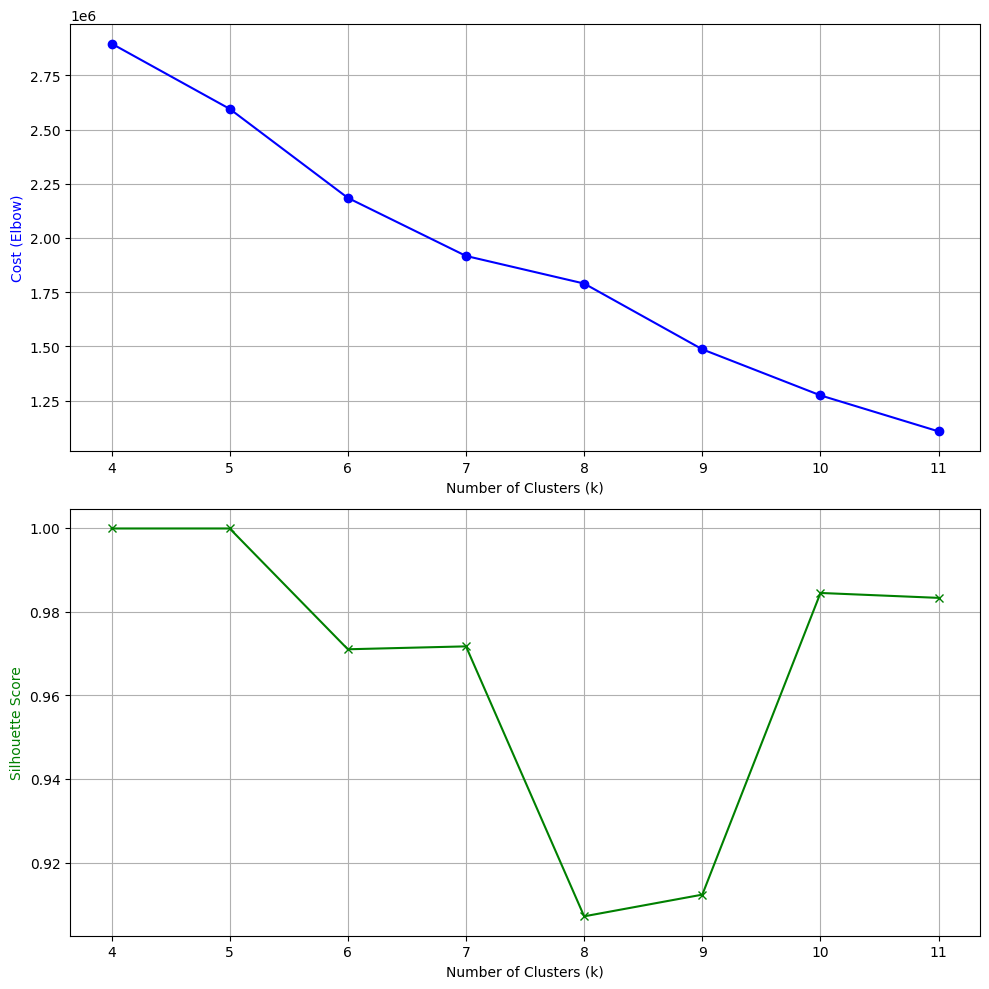

In [28]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, monotonically_increasing_id, stddev, count
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf

def calculate_feature_distinctiveness(cluster_profiles):
    """
    Calculate how distinctive each feature is across clusters
    """
    # Calculate the variance of each feature across clusters
    feature_variance = cluster_profiles.std()
    
    # Normalize the variance to get a distinctiveness score
    distinctiveness = feature_variance / feature_variance.max()
    
    return distinctiveness

def interpret_clusters(cluster_profiles):
    interpretations = {}
    
    # Calculate feature distinctiveness to weight interpretations
    distinctiveness = calculate_feature_distinctiveness(cluster_profiles)
    
    for cluster in cluster_profiles.index:
        features = cluster_profiles.columns.tolist()
        profile_components = []
        
        # Spending Behavior
        if 'purchases' in features:
            spend_level = cluster_profiles.loc[cluster, 'purchases']
            mean_spend = cluster_profiles['purchases'].mean()
            std_spend = cluster_profiles['purchases'].std()
            
            if spend_level > mean_spend + std_spend:
                profile_components.append("Aggressive Spender")
            elif spend_level < mean_spend - std_spend:
                profile_components.append("Conservative Spender")
        
        # Cash Advance Behavior
        if 'cash_advance' in features and 'cash_advance_frequency' in features:
            cash_advance = cluster_profiles.loc[cluster, 'cash_advance']
            cash_freq = cluster_profiles.loc[cluster, 'cash_advance_frequency']
            mean_cash = cluster_profiles['cash_advance'].mean()
            mean_freq = cluster_profiles['cash_advance_frequency'].mean()
            
            if cash_advance > mean_cash * 1.5 and cash_freq > mean_freq * 1.5:
                profile_components.append("High-Risk Cash Advance User")
            elif cash_advance < mean_cash * 0.5 and cash_freq < mean_freq * 0.5:
                profile_components.append("Minimal Cash Advance User")
        
        # Credit Utilization
        if 'balance' in features and 'credit_limit' in features:
            balance_ratio = cluster_profiles.loc[cluster, 'balance'] / cluster_profiles.loc[cluster, 'credit_limit']
            
            if balance_ratio > 0.7:
                profile_components.append("High Credit Utilization")
            elif balance_ratio < 0.3:
                profile_components.append("Low Credit Utilization")
            else:
                profile_components.append("Moderate Credit Utilization")
        
        # Payment Behavior
        if 'payments' in features and 'minimum_payments' in features:
            payment_ratio = cluster_profiles.loc[cluster, 'payments'] / cluster_profiles.loc[cluster, 'minimum_payments']
            
            if payment_ratio > 2:
                profile_components.append("Proactive Payer")
            elif payment_ratio < 1.2:
                profile_components.append("Minimum Payment Tendency")
        
        # Risk Assessment
        if 'balance' in features and 'credit_limit' in features and 'cash_advance' in features:
            risk_score = (
                cluster_profiles.loc[cluster, 'balance'] / cluster_profiles.loc[cluster, 'credit_limit'] * 0.4 +
                cluster_profiles.loc[cluster, 'cash_advance'] / cluster_profiles.loc[cluster, 'credit_limit'] * 0.6
            )
            
            if risk_score > 0.6:
                profile_components.append("High Financial Risk")
            elif risk_score < 0.3:
                profile_components.append("Low Financial Risk")
        
        # Finalize interpretation
        if profile_components:
            interpretations[cluster] = "; ".join(profile_components)
        else:
            interpretations[cluster] = "Undefined Customer Segment"
    
    return interpretations

def feature_engineering_and_segmentation(file_path: str, minio_bucket: str) -> str:
    spark = SparkSession.builder \
        .appName("AdvancedCustomerSegmentation") \
        .enableHiveSupport() \
        .getOrCreate()

    minio_client = boto3.client(
        's3',
        endpoint_url="http://192.168.80.155:32000",
        aws_access_key_id="admin",
        aws_secret_access_key="dlyticaD123"
    )

    today = datetime.now().strftime('%Y-%m-%d')
    local_path = "/tmp/raw_data.csv"
    minio_client.download_file(minio_bucket, file_path, local_path)
    df = spark.read.csv(local_path, header=True, inferSchema=True)

    if 'custid' in df.columns:
        df = df.withColumnRenamed("custid", "cif_id")

    # Enhanced feature engineering
    df = df.withColumn("balance_utilization_ratio", 
        when(col("credit_limit") != 0, col("balance") / col("credit_limit")).otherwise(0)
    )
    df = df.withColumn("cash_advance_intensity", 
        when(col("credit_limit") != 0, col("cash_advance") / col("credit_limit")).otherwise(0)
    )
    df = df.withColumn("payment_effort_ratio", 
        when(col("minimum_payments") != 0, col("payments") / col("minimum_payments")).otherwise(0)
    )
    df = df.na.fill(0)

    numeric_cols = [
        'purchases', 'oneoff_purchases', 'installments_purchases', 
        'cash_advance', 'cash_advance_frequency', 
        'balance', 'credit_limit', 
        'payments', 'minimum_payments',
        'balance_utilization_ratio', 
        'cash_advance_intensity', 
        'payment_effort_ratio'
    ]

    # Feature selection and transformation
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    assembled = assembler.transform(df.drop("cif_id"))
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaled_data = scaler.fit(assembled).transform(assembled)

    # Advanced clustering with PCA
    pca = PCA(k=3, inputCol="scaled_features", outputCol="pca_features")
    pca_data = pca.fit(scaled_data).transform(scaled_data)

    # Cluster number optimization
    evaluator = ClusteringEvaluator(featuresCol='pca_features')
    costs, silhouettes = [], []
    k_range = range(4, 12)  # Expanded range

    for k in k_range:
        kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")
        model = kmeans.fit(pca_data)
        predictions = model.transform(pca_data)
        cost = model.summary.trainingCost
        silhouette = evaluator.evaluate(predictions)
        costs.append(cost)
        silhouettes.append(silhouette)

    # Visualization of clustering metrics
    elbow_df = pd.DataFrame({"k": k_range, "cost": costs})
    silhouette_df = pd.DataFrame({"k": k_range, "silhouette": silhouettes})

    # Select optimal k with multiple criteria
    optimal_k = silhouette_df.loc[silhouette_df['silhouette'].idxmax(), 'k'] + 4

    # Plotting
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    ax1.plot(elbow_df['k'], elbow_df['cost'], marker='o', color='blue', label='Cost')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Cost (Elbow)', color='blue')
    ax1.grid(True)

    ax2.plot(silhouette_df['k'], silhouette_df['silhouette'], marker='x', color='green', label='Silhouette')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax2.grid(True)

    plt.tight_layout()
    plt.savefig('/tmp/cluster_diagnostics.png')

    # Final clustering
    kmeans = KMeans(k=optimal_k, seed=42, featuresCol="pca_features")
    model = kmeans.fit(pca_data)
    clustered_data = model.transform(pca_data)

    # Add cluster information to original dataframe
    df_with_id = df.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.join(df_with_id.select("row_id", "cif_id"), on="row_id").drop("row_id")

    # Generate cluster profiles
    summary = clustered_data.groupBy("prediction").agg(
        *[mean(col(c)).alias(c) for c in numeric_cols],
        *[stddev(col(c)).alias(f"{c}_std") for c in numeric_cols],
        count("cif_id").alias("cluster_size")  # Add count of customers in each cluster
    )
    cluster_profiles = summary.toPandas().set_index("prediction")
    
    # Get interpretations
    interpretations = interpret_clusters(cluster_profiles)

    print("Cluster Interpretations:")
    for cluster, interp in interpretations.items():
        # Get the cluster size
        cluster_size = int(cluster_profiles.loc[cluster, 'cluster_size'])
        print(f"Cluster {cluster}: {interp} (Size: {cluster_size} customers)")

    # Add interpretations to clustered data
    interpret_udf = udf(lambda x: interpretations.get(x, "Unknown"), StringType())
    clustered_data = clustered_data.withColumn("interpretation", interpret_udf(col("prediction")))

    # Detailed cluster distribution
    cluster_distribution = clustered_data.groupBy("prediction", "interpretation") \
        .agg(count("cif_id").alias("customer_count")) \
        .orderBy("customer_count", ascending=False)
    
    print("\nDetailed Cluster Distribution:")
    cluster_distribution.show(truncate=False)

    # Save results
    final_df = clustered_data.select("cif_id", "prediction", "interpretation").toPandas()
    final_csv = f"/tmp/segmentation_{today}.csv"
    final_df.to_csv(final_csv, index=False)
    minio_client.upload_file(final_csv, minio_bucket, f"results/segmentation_{today}.csv")

    return f"Advanced Segmentation completed using {optimal_k} clusters and results saved."

feature_engineering_and_segmentation(
    file_path="data/customer_segmentation_raw_data_10yrs_2025-03-27.csv",
    minio_bucket="ai360ctzn-customer-segmentation"
)

Cluster Interpretations:
Cluster 3: Low spenders; Rarely uses cash advances; Low balance-to-limit ratio (conservative)
Cluster 5: Low spenders; Rarely uses cash advances; Low balance-to-limit ratio (conservative)
Cluster 2: Low spenders; High balance-to-limit ratio (potentially at-risk)
Cluster 0: Low spenders; Rarely uses cash advances; High balance-to-limit ratio (potentially at-risk)
Cluster 4: Rarely uses cash advances; High balance-to-limit ratio (potentially at-risk)
Cluster 6: High spenders; High balance-to-limit ratio (potentially at-risk)
Cluster 1: High spenders; High balance-to-limit ratio (potentially at-risk)


'Segmentation completed using 7 clusters and results saved.'

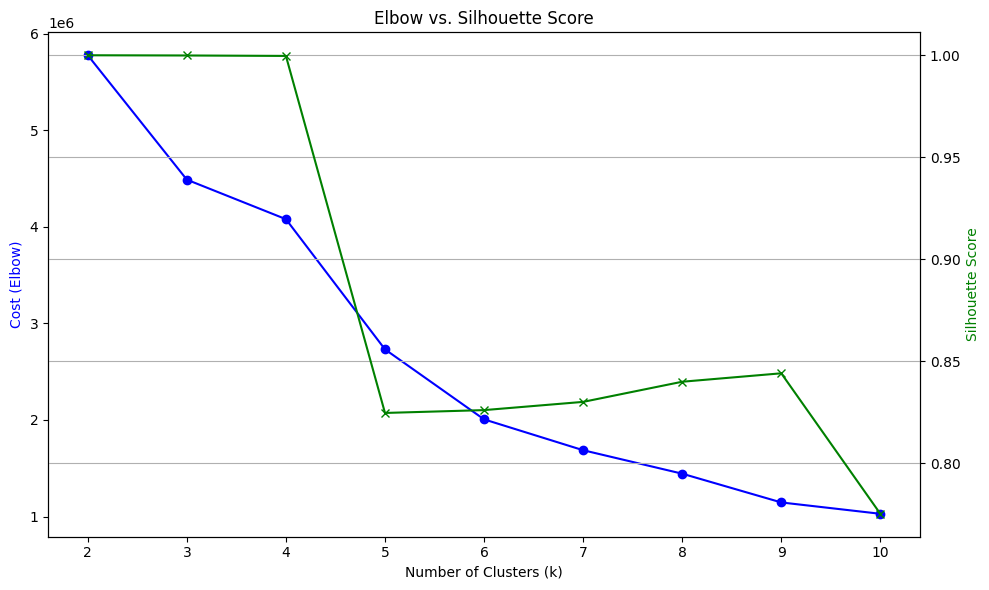

In [23]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, monotonically_increasing_id
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf

def interpret_clusters(cluster_profiles):
    interpretations = {}
    
    # Dynamically determine key features for each cluster
    for cluster in cluster_profiles.index:
        features = cluster_profiles.columns.tolist()
        profile = ""
        
        # Analyze spending patterns
        if any(f in features for f in ['purchases', 'oneoff_purchases', 'installments_purchases', 
                                     'new_oneoff_purchases_purchases', 'new_installments_purchases_purchases']):
            spend_level = cluster_profiles.loc[cluster, 'purchases'] if 'purchases' in cluster_profiles.columns else 0
            oneoff_ratio = cluster_profiles.loc[cluster, 'new_oneoff_purchases_purchases'] if 'new_oneoff_purchases_purchases' in cluster_profiles.columns else 0
            install_ratio = cluster_profiles.loc[cluster, 'new_installments_purchases_purchases'] if 'new_installments_purchases_purchases' in cluster_profiles.columns else 0
            
            if spend_level > cluster_profiles['purchases'].mean() * 1.2:
                profile += "High spenders; "
            elif spend_level < cluster_profiles['purchases'].mean() * 0.8:
                profile += "Low spenders; "
                
            if oneoff_ratio > install_ratio * 1.2:
                profile += "Prefers one-time purchases; "
            elif install_ratio > oneoff_ratio * 1.2:
                profile += "Prefers installment purchases; "
        
        # Analyze cash advance behavior
        if any(f in features for f in ['cash_advance', 'cash_advance_frequency', 'new_cash_advance_purchases_purchases']):
            cash_level = cluster_profiles.loc[cluster, 'cash_advance'] if 'cash_advance' in cluster_profiles.columns else 0
            cash_freq = cluster_profiles.loc[cluster, 'cash_advance_frequency'] if 'cash_advance_frequency' in cluster_profiles.columns else 0
            
            if cash_level > cluster_profiles['cash_advance'].mean() * 1.2 and cash_freq > cluster_profiles['cash_advance_frequency'].mean() * 1.2:
                profile += "Heavy cash advance users; "
            elif cash_level < cluster_profiles['cash_advance'].mean() * 0.8 and cash_freq < cluster_profiles['cash_advance_frequency'].mean() * 0.8:
                profile += "Rarely uses cash advances; "
        
        # Analyze balance and credit behavior
        if any(f in features for f in ['balance', 'credit_limit', 'new_balance_credit_limit']):
            balance_ratio = cluster_profiles.loc[cluster, 'new_balance_credit_limit'] if 'new_balance_credit_limit' in cluster_profiles.columns else 0
            
            if balance_ratio > 0.7:
                profile += "High balance-to-limit ratio (potentially at-risk); "
            elif balance_ratio < 0.3:
                profile += "Low balance-to-limit ratio (conservative); "
        
        # Analyze payment behavior
        if any(f in features for f in ['payments', 'minimum_payments', 'new_payments_credit_limit']):
            payment_ratio = cluster_profiles.loc[cluster, 'new_payments_credit_limit'] if 'new_payments_credit_limit' in cluster_profiles.columns else 0
            
            if payment_ratio > cluster_profiles['new_payments_credit_limit'].mean() * 1.2:
                profile += "Pays more than minimum; "
            elif payment_ratio < cluster_profiles['new_payments_credit_limit'].mean() * 0.8:
                profile += "Tends to pay minimum; "
        
        # Clean up and finalize the profile
        if profile:
            interpretations[cluster] = profile[:-2]  # Remove trailing "; "
        else:
            interpretations[cluster] = "No clear pattern identified"
    
    return interpretations

def feature_engineering_and_segmentation(file_path: str, minio_bucket: str) -> str:
    spark = SparkSession.builder \
        .appName("CustomerSegmentation") \
        .enableHiveSupport() \
        .getOrCreate()

    minio_client = boto3.client(
        's3',
        endpoint_url="http://192.168.80.155:32000",
        aws_access_key_id="admin",
        aws_secret_access_key="dlyticaD123"
    )

    today = datetime.now().strftime('%Y-%m-%d')
    local_path = "/tmp/raw_data.csv"
    minio_client.download_file(minio_bucket, file_path, local_path)
    df = spark.read.csv(local_path, header=True, inferSchema=True)

    if 'custid' in df.columns:
        df = df.withColumnRenamed("custid", "cif_id")

    df = df.withColumn("new_balance_credit_limit", when(col("credit_limit") != 0, col("balance") / col("credit_limit")).otherwise(0))
    df = df.withColumn("new_payments_credit_limit", when(col("minimum_payments") != 0, col("payments") / col("minimum_payments")).otherwise(0))
    df = df.na.fill(0)

    numeric_cols = [field.name for field in df.schema.fields if isinstance(field.dataType, DoubleType) and field.name not in ['cif_id']]

    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    assembled = assembler.transform(df.drop("cif_id"))
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaled_data = scaler.fit(assembled).transform(assembled)

    pca = PCA(k=2, inputCol="scaled_features", outputCol="pca_features")
    pca_data = pca.fit(scaled_data).transform(scaled_data)

    evaluator = ClusteringEvaluator(featuresCol='pca_features')
    costs, silhouettes = [], []
    k_range = range(2, 11)

    for k in k_range:
        kmeans = KMeans(k=k, seed=42, featuresCol="pca_features")
        model = kmeans.fit(pca_data)
        predictions = model.transform(pca_data)
        cost = model.summary.trainingCost
        silhouette = evaluator.evaluate(predictions)
        costs.append(cost)
        silhouettes.append(silhouette)

    elbow_df = pd.DataFrame({"k": k_range, "cost": costs})
    silhouette_df = pd.DataFrame({"k": k_range, "silhouette": silhouettes})

    optimal_k = silhouette_df.loc[silhouette_df['silhouette'].idxmax(), 'k'] + 5
    # optmial_k += 4 

    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(elbow_df['k'], elbow_df['cost'], marker='o', color='blue', label='Cost')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Cost (Elbow)', color='blue')

    ax2 = ax1.twinx()
    ax2.plot(silhouette_df['k'], silhouette_df['silhouette'], marker='x', color='green', label='Silhouette')
    ax2.set_ylabel('Silhouette Score', color='green')

    plt.title('Elbow vs. Silhouette Score')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('/tmp/cluster_diagnostics.png')

    kmeans = KMeans(k=optimal_k, seed=42, featuresCol="pca_features")
    model = kmeans.fit(pca_data)
    clustered_data = model.transform(pca_data)

    df_with_id = df.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.join(df_with_id.select("row_id", "cif_id"), on="row_id").drop("row_id")

    summary = clustered_data.groupBy("prediction").agg(*[mean(col(c)).alias(c) for c in numeric_cols])
    cluster_profiles = summary.toPandas().set_index("prediction")
    interpretations = interpret_clusters(cluster_profiles)

    print("Cluster Interpretations:")
    for cluster, interp in interpretations.items():
        print(f"Cluster {cluster}: {interp}")

    interpret_udf = udf(lambda x: interpretations.get(x, "Unknown"), StringType())
    clustered_data = clustered_data.withColumn("interpretation", interpret_udf(col("prediction")))

    final_df = clustered_data.select("cif_id", "prediction", "interpretation").toPandas()
    final_csv = f"/tmp/segmentation_{today}.csv"
    final_df.to_csv(final_csv, index=False)
    minio_client.upload_file(final_csv, minio_bucket, f"results/segmentation_{today}.csv")

    return f"Segmentation completed using {optimal_k} clusters and results saved."

feature_engineering_and_segmentation(
    file_path="data/customer_segmentation_raw_data_10yrs_2025-03-27.csv",
    minio_bucket="ai360ctzn-customer-segmentation"
)

In [ ]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, mean, monotonically_increasing_id, stddev, count, abs
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import BisectingKMeans  # Changed from KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import udf

def calculate_feature_distinctiveness(cluster_profiles):
    """
    Enhanced feature distinctiveness calculation
    """
    # Calculate the variance of each feature across clusters
    feature_variance = cluster_profiles.std()
    
    # Normalize the variance to get a distinctiveness score with more nuanced weighting
    distinctiveness = feature_variance / (feature_variance.max() + 1e-10)
    
    return distinctiveness

def interpret_clusters(cluster_profiles):
    interpretations = {}
    
    # Calculate feature distinctiveness to weight interpretations
    distinctiveness = calculate_feature_distinctiveness(cluster_profiles)
    
    for cluster in cluster_profiles.index:
        features = cluster_profiles.columns.tolist()
        profile_components = []
        
        # More nuanced spending behavior
        if 'purchases' in features:
            spend_level = cluster_profiles.loc[cluster, 'purchases']
            mean_spend = cluster_profiles['purchases'].mean()
            std_spend = cluster_profiles['purchases'].std()
            
            if spend_level > mean_spend + 1.5 * std_spend:
                profile_components.append("High Spender")
            elif spend_level < mean_spend - 1.5 * std_spend:
                profile_components.append("Low Spender")
            else:
                profile_components.append("Moderate Spender")
        
        # Refined Cash Advance Behavior
        if 'cash_advance' in features and 'cash_advance_frequency' in features:
            cash_advance = cluster_profiles.loc[cluster, 'cash_advance']
            cash_freq = cluster_profiles.loc[cluster, 'cash_advance_frequency']
            mean_cash = cluster_profiles['cash_advance'].mean()
            mean_freq = cluster_profiles['cash_advance_frequency'].mean()
            
            if cash_advance > mean_cash * 2 and cash_freq > mean_freq * 2:
                profile_components.append("Intensive Cash Advance User")
            elif cash_advance < mean_cash * 0.5 and cash_freq < mean_freq * 0.5:
                profile_components.append("Rare Cash Advance User")
        
        # More granular Credit Utilization
        if 'balance' in features and 'credit_limit' in features:
            balance_ratio = cluster_profiles.loc[cluster, 'balance'] / (cluster_profiles.loc[cluster, 'credit_limit'] + 1e-10)
            
            if balance_ratio > 0.8:
                profile_components.append("Very High Credit Utilization")
            elif balance_ratio > 0.5:
                profile_components.append("High Credit Utilization")
            elif balance_ratio < 0.2:
                profile_components.append("Low Credit Utilization")
            else:
                profile_components.append("Moderate Credit Utilization")
        
        # Detailed Payment Behavior
        if 'payments' in features and 'minimum_payments' in features:
            payment_ratio = cluster_profiles.loc[cluster, 'payments'] / (cluster_profiles.loc[cluster, 'minimum_payments'] + 1e-10)
            
            if payment_ratio > 3:
                profile_components.append("Aggressive Overpayer")
            elif payment_ratio > 2:
                profile_components.append("Consistent Overpayer")
            elif payment_ratio < 1.2:
                profile_components.append("Minimum Payment User")
        
        # Enhanced Risk Assessment
        if 'balance' in features and 'credit_limit' in features and 'cash_advance' in features:
            risk_score = (
                cluster_profiles.loc[cluster, 'balance'] / (cluster_profiles.loc[cluster, 'credit_limit'] + 1e-10) * 0.4 +
                cluster_profiles.loc[cluster, 'cash_advance'] / (cluster_profiles.loc[cluster, 'credit_limit'] + 1e-10) * 0.6
            )
            
            if risk_score > 0.7:
                profile_components.append("Extremely High Financial Risk")
            elif risk_score > 0.5:
                profile_components.append("High Financial Risk")
            elif risk_score < 0.2:
                profile_components.append("Low Financial Risk")
            else:
                profile_components.append("Moderate Financial Risk")
        
        # Finalize interpretation
        if profile_components:
            interpretations[cluster] = "; ".join(profile_components)
        else:
            interpretations[cluster] = "Undefined Customer Segment"
    
    return interpretations

def feature_engineering_and_segmentation(file_path: str, minio_bucket: str) -> str:
    spark = SparkSession.builder \
        .appName("AdvancedCustomerSegmentation") \
        .enableHiveSupport() \
        .getOrCreate()

    minio_client = boto3.client(
        's3',
        endpoint_url="http://192.168.80.155:32000",
        aws_access_key_id="admin",
        aws_secret_access_key="dlyticaD123"
    )

    today = datetime.now().strftime('%Y-%m-%d')
    local_path = "/tmp/raw_data.csv"
    minio_client.download_file(minio_bucket, file_path, local_path)
    df = spark.read.csv(local_path, header=True, inferSchema=True)

    if 'custid' in df.columns:
        df = df.withColumnRenamed("custid", "cif_id")

    # Enhanced feature engineering with more robust calculations
    df = df.withColumn("balance_utilization_ratio", 
        when(col("credit_limit") != 0, col("balance") / col("credit_limit")).otherwise(0)
    )
    df = df.withColumn("cash_advance_intensity", 
        when(col("credit_limit") != 0, col("cash_advance") / col("credit_limit")).otherwise(0)
    )
    df = df.withColumn("payment_effort_ratio", 
        when(col("minimum_payments") != 0, col("payments") / col("minimum_payments")).otherwise(0)
    )
    
    # Advanced feature: Spending diversity
    df = df.withColumn("purchase_diversity", 
        abs(col("oneoff_purchases") - col("installments_purchases")) / 
        (abs(col("oneoff_purchases") + col("installments_purchases")) + 1e-10)
    )
    
    df = df.na.fill(0)

    # Expanded feature set with diversity and intensity metrics
    numeric_cols = [
        'purchases', 'oneoff_purchases', 'installments_purchases', 
        'cash_advance', 'cash_advance_frequency', 
        'balance', 'credit_limit', 
        'payments', 'minimum_payments',
        'balance_utilization_ratio', 
        'cash_advance_intensity', 
        'payment_effort_ratio',
        'purchase_diversity'
    ]

    # Feature selection and transformation with more robust scaling
    assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
    assembled = assembler.transform(df.drop("cif_id"))
    scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withMean=True, withStd=True)
    scaled_data = scaler.fit(assembled).transform(assembled)

    # Advanced clustering dimensionality reduction
    pca = PCA(k=5, inputCol="scaled_features", outputCol="pca_features")
    pca_data = pca.fit(scaled_data).transform(scaled_data)

    # Clustering optimization with multiple metrics
    evaluator = ClusteringEvaluator(featuresCol='pca_features')
    costs, silhouettes, separation_scores = [], [], []
    k_range = range(6, 15)  # Expanded and adjusted range

    for k in k_range:
        # Use BisectingKMeans for potentially more balanced clusters
        kmeans = BisectingKMeans(k=k, seed=42, featuresCol="pca_features")
        model = kmeans.fit(pca_data)
        predictions = model.transform(pca_data)
        
        cost = model.summary.trainingCost if hasattr(model.summary, 'trainingCost') else 0
        silhouette = evaluator.evaluate(predictions)
        
        # Calculate separation score (distance between cluster centers)
        centers = model.clusterCenters()
        separation = np.mean([np.min(np.linalg.norm(centers[i] - centers[j])) 
                               for i in range(len(centers)) 
                               for j in range(i+1, len(centers))])
        
        costs.append(cost)
        silhouettes.append(silhouette)
        separation_scores.append(separation)

    # Multi-criteria optimal k selection
    k_metrics = pd.DataFrame({
        'k': k_range, 
        'cost': costs, 
        'silhouette': silhouettes, 
        'separation': separation_scores
    })
    
    # Normalize metrics and combine for optimal k selection
    k_metrics['normalized_cost'] = (k_metrics['cost'] - k_metrics['cost'].min()) / (k_metrics['cost'].max() - k_metrics['cost'].min())
    k_metrics['normalized_silhouette'] = (k_metrics['silhouette'] - k_metrics['silhouette'].min()) / (k_metrics['silhouette'].max() - k_metrics['silhouette'].min())
    k_metrics['normalized_separation'] = (k_metrics['separation'] - k_metrics['separation'].min()) / (k_metrics['separation'].max() - k_metrics['separation'].min())
    
    # Weighted scoring (you can adjust weights based on domain knowledge)
    k_metrics['composite_score'] = (
        0.3 * (1 - k_metrics['normalized_cost']) +  # Lower cost is better
        0.4 * k_metrics['normalized_silhouette'] +  # Higher silhouette is better
        0.3 * k_metrics['normalized_separation']    # Higher separation is better
    )
    
    optimal_k = k_metrics.loc[k_metrics['composite_score'].idxmax(), 'k']

    # Plotting cluster diagnostics
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
    ax1.plot(k_metrics['k'], k_metrics['cost'], marker='o', color='blue', label='Cost')
    ax1.set_xlabel('Number of Clusters (k)')
    ax1.set_ylabel('Cost', color='blue')
    ax1.grid(True)

    ax2.plot(k_metrics['k'], k_metrics['silhouette'], marker='x', color='green', label='Silhouette')
    ax2.set_xlabel('Number of Clusters (k)')
    ax2.set_ylabel('Silhouette Score', color='green')
    ax2.grid(True)

    ax3.plot(k_metrics['k'], k_metrics['separation'], marker='^', color='red', label='Cluster Separation')
    ax3.set_xlabel('Number of Clusters (k)')
    ax3.set_ylabel('Cluster Separation', color='red')
    ax3.grid(True)

    plt.tight_layout()
    plt.savefig('/tmp/cluster_diagnostics_advanced.png')

    # Final clustering with optimal k
    kmeans = BisectingKMeans(k=optimal_k, seed=42, featuresCol="pca_features")
    model = kmeans.fit(pca_data)
    clustered_data = model.transform(pca_data)

    # Add cluster information to original dataframe
    df_with_id = df.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.withColumn("row_id", monotonically_increasing_id())
    clustered_data = clustered_data.join(df_with_id.select("row_id", "cif_id"), on="row_id").drop("row_id")

    # Generate comprehensive cluster profiles
    summary = clustered_data.groupBy("prediction").agg(
        *[mean(col(c)).alias(c) for c in numeric_cols],
        *[stddev(col(c)).alias(f"{c}_std") for c in numeric_cols],
        count("cif_id").alias("cluster_size")
    )
    cluster_profiles = summary.toPandas().set_index("prediction")
    
    # Get interpretations
    interpretations = interpret_clusters(cluster_profiles)

    print("Cluster Interpretations:")
    for cluster, interp in interpretations.items():
        cluster_size = int(cluster_profiles.loc[cluster, 'cluster_size'])
        print(f"Cluster {cluster}: {interp} (Size: {cluster_size} customers)")

    # Add interpretations to clustered data
    interpret_udf = udf(lambda x: interpretations.get(x, "Unknown"), StringType())
    clustered_data = clustered_data.withColumn("interpretation", interpret_udf(col("prediction")))

    # Detailed cluster distribution
    cluster_distribution = clustered_data.groupBy("prediction", "interpretation") \
        .agg(count("cif_id").alias("customer_count")) \
        .orderBy("customer_count", ascending=False)
    
    print("\nDetailed Cluster Distribution:")
    cluster_distribution.show(truncate=False)

    # Save results
    final_df = clustered_data.select("cif_id", "prediction", "interpretation").toPandas()

    final_df.show(100)
    final_csv = f"/tmp/segmentation_{today}.csv"
    final_df.to_csv(final_csv, index=False)
    minio_client.upload_file(final_csv, minio_bucket, f"results/segmentation_{today}.csv")

    return f"Advanced Segmentation completed using {optimal_k} clusters and results saved."

feature_engineering_and_segmentation(
    file_path="data/customer_segmentation_raw_data_10yrs_2025-03-27.csv",
    minio_bucket="ai360ctzn-customer-segmentation"
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/28 10:16:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/28 10:16:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/03/28 10:16:31 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/03/28 10:16:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/28 10:16:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [4]:
! pip install matplotlib

  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.56.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (101 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pillow-11.1.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.6 MB)
Using cached contourpy-1.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (326 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.56.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.9 MB)
Usi